<a href="https://colab.research.google.com/github/milvish/Computer_Vision_Projects/blob/main/CV_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Смешивание изображений с помощью пирамид

In [ ]:
# Загрузка картинок
!mkdir media
!wget https://github.com/milvish/Computer_Vision_Projects/blob/main/media/horse3.jpg?raw=true -P media &> /dev/null
!wget https://github.com/milvish/Computer_Vision_Projects/blob/main/media/girl3.png?raw=true -P media &> /dev/null

mkdir: cannot create directory ‘media’: File exists


In [ ]:
import numpy as np

from skimage import io, img_as_float
from PIL import Image

In [ ]:
image1 = img_as_float(io.imread('media/pomegranate2.jpg'))
image2 = img_as_float(io.imread('media/orange2.png'))
mask = np.zeros_like(image1)
mask[:,image1.shape[0]//2:] = 1

Пирамида Гаусса

Пирамида гаусса строится по рекурсивной формуле:

G(I)0=I 

G(I)i=d(s(G(I)i−1)) 

s  — фильтр гаусса

d  - операция понижения размерности в 2 раза

In [ ]:
from skimage import transform

# Реализуйте функцию создания пирамиды Гаусса
def build_gaussian_pyromid(image, levels):
    pyromid = [image]
    for _ in range(levels - 1):
        pyromid.append(transform.resize(pyromid[-1], 
                                        [pyromid[-1].shape[0]//2, pyromid[-1].shape[1]//2]
                                       ))
    return pyromid

Пирамида Лапласса

Нас интересует инвертируемая версия пирамиды Лапласса. Её формулы:

L(I)i=G(I)i−u(G(I)i+1) 

L(I)k=G(I)k 

u  — операция увеличения размерности в 2 раза

In [ ]:
# Реализуйте функцию создания пирамиды Лапласса
def build_laplassian_pyromid(image, levels):
    gaussian = build_gaussian_pyromid(image, levels)
    pyromid = []
    for i in range(levels - 1):
        pyromid.append(gaussian[i] - transform.resize(gaussian[i+1], gaussian[i].shape[:2]))
    pyromid.append(gaussian[-1])
    return pyromid

In [ ]:
# Реализуйте функцию инвертации Пирамиды Лапласса (восстановления исходного изображения)
def invert_laplassian_pyromid(pyromid):
    gaussian_pyromid = [0 for _ in range(len(pyromid))]
    gaussian_pyromid[-1] = pyromid[-1]
    for i in range(-2, -len(pyromid)-1, -1):
        gaussian_pyromid[i] = transform.resize(gaussian_pyromid[i+1], pyromid[i].shape[:2]) + pyromid[i]
    return np.clip(gaussian_pyromid[0], 0, 1)

In [ ]:
# Небольшая проверка что все работает
lp = build_laplassian_pyromid(image1, 5)
assert np.allclose(invert_laplassian_pyromid(lp), image1)

Смешивание изображений

Для смешивания нам необходимо построить лаплассовы пирамиды для изображений и гауссовы для масок. (Чтобы получить вторую маску, надо инвертировать первую).

Для смешивания мы будем создавать новую пирамиду лапласса. Результат — восстановлененное изображение из этой новой пирамиды.

Формула смешивания:

Lf(I)i=G(M1)i∗L(I1)i+G(M2)i∗L(I2)i

In [ ]:
# Реализуйте смешивание изображений
def blend_images(image1, image2, mask, levels=5):
    gaussian_mask1 = build_gaussian_pyromid(mask, levels)
    gaussian_mask2 = build_gaussian_pyromid(1-mask, levels)
    
    laplassian1 = build_laplassian_pyromid(image1, levels)
    laplassian2 = build_laplassian_pyromid(image2, levels)
    
    blended_laplassian = [
        lap1 * gm1 + lap2 * gm2
        for lap1, gm1, lap2, gm2 in zip(laplassian1, gaussian_mask1, laplassian2, gaussian_mask2)
    ]
    
    return invert_laplassian_pyromid(blended_laplassian)

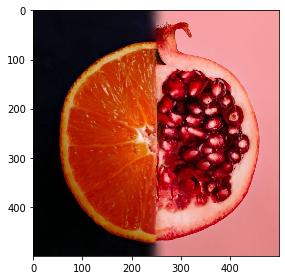

In [ ]:
result = blend_images(image1, image2, mask)
io.imshow(result)


#